# Importing Dependencies & extracting dataset
----
This part of the process deals with the _Extraction_ part of the ***E***TL. Firstly, the needed modules will be imported and then the dataset. 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import tensorflow_datasets as tfds

Found GPU at: /device:GPU:0


In [2]:
import pandas as pd
import numpy as np
import re

import keras
from keras.preprocessing import sequence as seq
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, LSTM, GlobalMaxPool1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import *

Using TensorFlow backend.


In [18]:
### In case, one wanted to upload the files to a File Storage (in case Google Drive)
from google.colab import drive

drive.mount('/content/gdrive/')

KeyboardInterrupt: ignored

In [16]:
### Some commands to create directory structure and rename file - already executed in the Data Exploration Notebook
# %cd /content/gdrive/My\ Drive
# !rm -r projects
# !mkdir projects
# !mkdir projects/capstone
# !mkdir projects/capstone/checkpoints
%cd /content/gdrive/My\ Drive/projects/capstone

[Errno 2] No such file or directory: '/content/gdrive/My Drive/projects/capstone'
/content


In [3]:
### Already executed in the Data Exploration Notebook
!rm trainingandtestdata.zip -f
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip 
!unzip trainingandtestdata.zip
!mv training.1600000.processed.noemoticon.csv sentiment_analysis_trainingset.csv

--2020-06-29 16:44:51--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-06-29 16:44:52--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  20.7MB/s    in 4.6s    

2020-06-29 16:44:57 (16.9 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


## Loading the dataset into Pandas framework:

In [4]:
nameColumns = ["sentiment", "id", "date", "query", "user", "post"]

fullDataset = pd.read_csv('sentiment_analysis_trainingset.csv', 
                          header=None, 
                          names=nameColumns, 
                          encoding='latin1', 
                          engine='python')

In [5]:
print(fullDataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   post       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


## Initial sampling
In order to gain time-efficiency, a random sample was extracted from the 1.6MM datapoints.


In [6]:
sampleDataset = fullDataset.sample(frac=0.1, replace = None, random_state=300)
sampleDataset.index = range(len(sampleDataset))
sampleDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  160000 non-null  int64 
 1   id         160000 non-null  int64 
 2   date       160000 non-null  object
 3   query      160000 non-null  object
 4   user       160000 non-null  object
 5   post       160000 non-null  object
dtypes: int64(2), object(4)
memory usage: 7.3+ MB


# Tranformations
---
In this part, we will run the necessary data transformations (E***T***L):

## (re)tagging sentiments
Ensure that inputs labels will be `0` or `1`

In [7]:
sampleDatasetLabels = sampleDataset.sentiment.values
sampleDatasetLabels[sampleDatasetLabels == 4] = 1

## tweets text treatment
Here we will treat the Twitter text posts, to remove all sort of noise and non-essencial for our analysis:

In [8]:
def TweetTreament(stringTweet):
    tweet = re.sub(r"https?://[a-zA-Z0-9./]+", ' ', stringTweet)  # remove the URL links
    tweet = re.sub(r"(w|W){3}[a-zA-Z0-9./]+", ' ', tweet)         # remove the www references
    tweet = re.sub(r"@[a-zA-Z0-9]+", ' ', tweet)                  # remove references from accounts/profiles, using @ 
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)                  # keep only letters & punctuations marks
    tweet = re.sub(r" +", ' ', tweet).strip()                     # remove potential excess of whitespaces before, in and after
    
    return tweet

cleanedTweets = [TweetTreament(t) for t in sampleDataset.post]

## tokenization
Tokenization is the process of converting each word in a text to an unique number (integer), called tokens. This is a common task in NLP, since computers learn words from numbers, not characters. Luckily, TensorFlow support us with all necessary methods.

The method `SubwordTextEncoder.build_from_corpus()` allows us to build a vocabulary using the universe of words in our dataset. 

The `.encode()` method convert each word in the Tweet into a token. This process is invertible by using `.decode()`.


In [9]:
targetVocab = 2**16

tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                                          cleanedTweets, 
                                          target_vocab_size=targetVocab)

tokenizedData = [tokenizer.encode(sentence) for sentence in cleanedTweets]

> **point of decision:** the vocabulary size is a critical variable, as a large vocabulary size will result in a high number of word embedding parameters in the model, and therefore a large storage or memory. 
> Searching in Google, we see that a average Englisch speaker knows around 20.000-40.000 words. For our experiment, we will use the `targetVocab = 2**16`, or the most 65.536 important words.

## padding
Since we will use a Convolutional Neural Network (CNN)  model, padding is required and it improves the model performance.

Some tweets have more words than others, and this is where the padding is necessary.

We need to have the inputs with the same size, so padding represents the process of normalizing the length for each tokenized tweet by completing it with `0`.

Luckily, Keras `sequence.pad_sequences()` does this task for us. For common length (`maxLength`) we will use the maximum length found in our sample. 

In [10]:
maxLength = max([len(p) for p in tokenizedData])

paddedData = tf.keras.preprocessing.sequence.pad_sequences(tokenizedData,
                                                           value=0,
                                                           padding="pre",
                                                           maxlen=maxLength)
print(maxLength)

58


In [ ]:
paddedData[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,   774,  5919,
         589,   208,    86, 53975], dtype=int32)

# Loading

## Spliting data into training/testing set
As best practice, we will split our dataset in two groups: training set (80%) and testing set (20%).

In [12]:
testSize = int(len(paddedData) * 0.2)
print('The testing set has {0} datapoints\n'.format(testSize))

testInputs = paddedData[-testSize:]
testLabels = sampleDatasetLabels[-testSize:]
trainInputs = paddedData[:-testSize]
trainLabels = sampleDatasetLabels[:-testSize]

### Checking the shape of the model's inputs and labels 
print('Size of testing Inputs:', len(testInputs))
print('Size of testing Labels:', len(testLabels))
print('\nSize of training Inputs:', len(trainInputs))
print('Size of training Inputs:', len(trainLabels))
print('\nFirst observation of training label:', trainLabels[0])
print('\nFirst observation of training inputs:', trainInputs[0])
print('\nTraining inputs shape:', trainInputs[0].shape)

The testing set has 32000 datapoints

Size of testing Inputs: 32000
Size of testing Labels: 32000

Size of training Inputs: 128000
Size of training Inputs: 128000

First observation of training label: 1

First observation of training inputs: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0   774  5919   589   208    86 53975]

Training inputs shape: (58,)


# Model Specification, Training and Evaluation
This section we will present the baseline model (LSTM) and two challenging models (CNN and the hybrid CNN-LSTM)

## Baseline model
As a baseline model, the Long Short-Term Memory networks (LSTM) was chosen. 

The LSTM are a special type of Recurrent Neural Networks (RNN). 

RNNs models for text classification take in consideration not only individual words, but also the order they appear in.


In [13]:
def BaselineModel():
  max_features = targetVocab
  maxlen = maxLength
  embedding_size = 128

  print('Baseline model building...')
  model = Sequential()

  model.add(Embedding(max_features, 
                      embedding_size,
                      input_length=maxlen))
  model.add(LSTM(128,dropout=0.2))
  
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  print('Compile baseline model...')  
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

  return model

**initialization**

In [14]:
batch_size = 32
epoch = 10

baselineModel = BaselineModel()
baselineModel.summary()

Baseline model building...
Compile baseline model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 128)           8388608   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 8,520,321
Trainable params: 8,520,321
Non-trainable params: 0
_________________________________________________________________


**training**

In [19]:
#checkPath = './checkpoints/baseline-weights-improvement-{epoch:02d}.hdf5'
#checkpoint = ModelCheckpoint(checkPath, monitor='val_acc', verbose=1, mode='max',save_best_only=True)

history = baselineModel.fit(trainInputs, trainLabels,
          batch_size=batch_size,
          epochs=epoch,
          validation_data=(testInputs, testLabels))

Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 733s 6ms/step - loss: 0.3572 - acc: 0.8418 - val_loss: 0.4593 - val_acc: 0.7945
Epoch 2/10
128000/128000 [==============================] - 731s 6ms/step - loss: 0.2654 - acc: 0.8867 - val_loss: 0.5384 - val_acc: 0.7805
Epoch 3/10
128000/128000 [==============================] - 732s 6ms/step - loss: 0.1851 - acc: 0.9231 - val_loss: 0.6261 - val_acc: 0.7704
Epoch 4/10
128000/128000 [==============================] - 735s 6ms/step - loss: 0.1251 - acc: 0.9489 - val_loss: 0.8178 - val_acc: 0.7639
Epoch 5/10
128000/128000 [==============================] - 731s 6ms/step - loss: 0.0873 - acc: 0.9650 - val_loss: 0.9556 - val_acc: 0.7558
Epoch 6/10
128000/128000 [==============================] - 732s 6ms/step - loss: 0.0638 - acc: 0.9745 - val_loss: 1.1078 - val_acc: 0.7533
Epoch 7/10
128000/128000 [==============================] - 732s 6ms/step - loss: 0.0493 - acc: 0.9805 - val_

**evalutation**

In [20]:
import matplotlib.pyplot as plt

def PlotEvaluation(history):
  plt.style.use('seaborn')
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(18, 4))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and Validation - Accuracy')
  plt.xticks(range(1, len(acc)+1, 1))
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation - Loss')
  plt.xticks(range(1, len(acc)+1, 1))    
  plt.legend()

128000/128000 [==============================] - 55s 427us/step
The results for the baseline model using under training set have an accuracy of 0.012525999813743511 and a loss of 0.9953437447547913
32000/32000 [==============================] - 13s 420us/step
The results for the baseline model using under testing set have an accuracy of 1.5517427724152804 and a loss of 0.7493125200271606


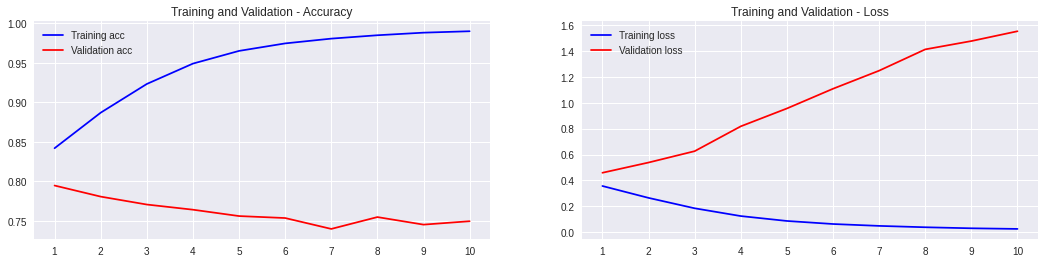

In [21]:
lossTrainBase, accTrainBase = baselineModel.evaluate(trainInputs, trainLabels, batch_size=batch_size)
print("The results for the baseline model using under training set have an accuracy of {0} and a loss of {1}".format(lossTrainBase, accTrainBase))

lossTestBase, accTestBase = baselineModel.evaluate(testInputs, testLabels, batch_size=batch_size)
print("The results for the baseline model using under testing set have an accuracy of {0} and a loss of {1}".format(lossTestBase, accTestBase))

PlotEvaluation(history)

## Challenging Model: CNN
Convolution Neural Networks (CNNs) are a class of deep, feed-forward neural networks, and use a variation of multilayer perceptrons designed to require minimal preprocessing.

They are generally know for a major breakthroughs in Image Classification, though they also have perform quite well in NLP classification tasks as, Sentiment Analysis, Span Detection, Auto tagging of customer queries and Topic Categorization.

In [ ]:
def ChallengerCNN():

  max_features = targetVocab
  maxlen = maxLength
  embedding_size = 128
  kernel_size = 5
  filters = 64

  print('Challenger CNN model building...')
  model = Sequential()

  model.add(Embedding(max_features, 
                      embedding_size,
                      input_length=maxlen))
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.25))
  
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  print('Compile Challenger CNN model...')  
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

  return model

**initialization**

In [ ]:
batch_size = 32
epoch = 10

cnnModel = ChallengerCNN()
cnnModel.summary()

Challenger CNN model building...
Compile challenger CNN model...
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 58, 128)           8388608   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 54, 64)            41024     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 129       
______________________________________________________

**training**

In [ ]:
checkPath = './checkpoints/cnn-weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkPath, monitor='val_acc', verbose=1, mode='max',save_best_only=True)

history = cnnModel.fit(trainInputs, trainLabels,
          batch_size=batch_size,
          epochs=epoch,
          validation_data=(testInputs, testLabels),
          callbacks = [checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 57s 446us/step - loss: 0.4845 - acc: 0.7645 - val_loss: 0.4480 - val_acc: 0.7915

Epoch 00001: val_acc improved from -inf to 0.79153, saving model to ./checkpoints/cnn-weights-improvement-01.hdf5
Epoch 2/10
128000/128000 [==============================] - 57s 445us/step - loss: 0.3190 - acc: 0.8636 - val_loss: 0.4849 - val_acc: 0.7865

Epoch 00002: val_acc did not improve from 0.79153
Epoch 3/10
128000/128000 [==============================] - 57s 446us/step - loss: 0.1473 - acc: 0.9423 - val_loss: 0.6670 - val_acc: 0.7744

Epoch 00003: val_acc did not improve from 0.79153
Epoch 4/10
128000/128000 [==============================] - 57s 442us/step - loss: 0.0686 - acc: 0.9739 - val_loss: 0.9100 - val_acc: 0.7662

Epoch 00004: val_acc did not improve from 0.79153
Epoch 5/10
128000/128000 [==============================] - 57s 442us/step - loss: 0.0441 - acc: 0.9837 - val_loss: 1

**evaluation**

128000/128000 [==============================] - 9s 71us/step
The results for the CNN model using under training set have an accuracy of 0.009037524285920768 and a loss of 0.9962812662124634
32000/32000 [==============================] - 2s 72us/step
The results for the CNN model using under testing set have an accuracy of 1.6468651015758515 and a loss of 0.75390625


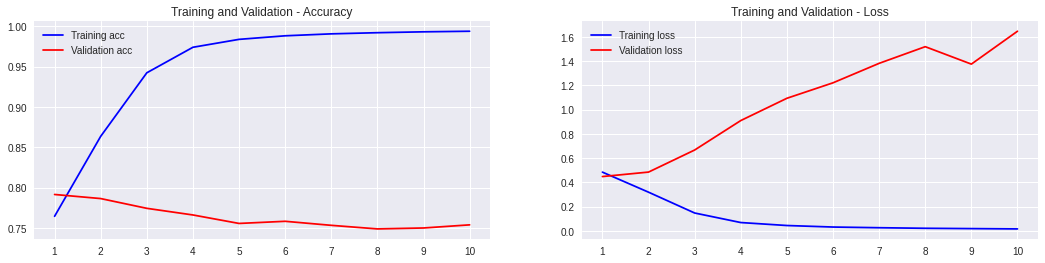

In [ ]:
lossTrainCNN, accTrainCNN= cnnModel.evaluate(trainInputs, trainLabels, batch_size=batch_size)
print("The results for the CNN model using under training set have an accuracy of {0} and a loss of {1}".format(lossTrainCNN, accTrainCNN))

lossTestCNN, accTestCNN= cnnModel.evaluate(testInputs, testLabels, batch_size=batch_size)
print("The results for the CNN model using under testing set have an accuracy of {0} and a loss of {1}".format(lossTestCNN, accTestCNN))

PlotEvaluation(history)

## Challenging Model: CNN-LSTM
CNNs models are trained to recognize patterns across space, while the CNN-LSTM are a class of models learn patterns both in space and time.

In [ ]:
def ChallengerLSTM():
  max_features = targetVocab
  maxlen = maxLength
  embedding_size = 128
  kernel_size = 5
  filters = 64

  print('Challenger CNN-LSTM model building...')
  model = Sequential()

  model.add(Embedding(max_features, 
                      embedding_size, 
                      input_length=maxlen))  
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='valid',
                  activation='relu'))
  model.add(MaxPooling1D(pool_size=4))
  model.add(LSTM(128, dropout=0.2))
  
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  print('Compile challenger CNN-LSTM model...')  
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

  return model

**initialization**

In [ ]:
batch_size = 32
epoch = 10

lstmModel = ChallengerLSTM()
lstmModel.summary()

Challenger CNN-LSTM model building...
Compile challenger CNN-LSTM model...
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 58, 128)           8388608   
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 54, 64)            41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_42 (Activation)   (None, 1)                 0         
Total params: 8,528,577
Trainable params: 8,

**training**

In [ ]:
checkPath = './checkpoints/lstm-weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkPath, monitor='val_acc', verbose=1, mode='max',save_best_only=True)

history = lstmModel.fit(trainInputs, trainLabels,
          batch_size=batch_size,
          epochs=epoch,
          validation_data=(testInputs, testLabels),
          callbacks = [checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 245s 2ms/step - loss: 0.5358 - acc: 0.7288 - val_loss: 0.5100 - val_acc: 0.7495

Epoch 00001: val_acc improved from -inf to 0.74953, saving model to ./checkpoints/lstm-weights-improvement-01.hdf5
Epoch 2/10
128000/128000 [==============================] - 243s 2ms/step - loss: 0.4105 - acc: 0.8126 - val_loss: 0.5264 - val_acc: 0.7440

Epoch 00002: val_acc did not improve from 0.74953
Epoch 3/10
128000/128000 [==============================] - 243s 2ms/step - loss: 0.2801 - acc: 0.8779 - val_loss: 0.6460 - val_acc: 0.7292

Epoch 00003: val_acc did not improve from 0.74953
Epoch 4/10
128000/128000 [==============================] - 241s 2ms/step - loss: 0.1878 - acc: 0.9206 - val_loss: 0.8378 - val_acc: 0.7233

Epoch 00004: val_acc did not improve from 0.74953
Epoch 5/10
128000/128000 [==============================] - 239s 2ms/step - loss: 0.1403 - acc: 0.9404 - val_loss: 0.980

**evaluation**

128000/128000 [==============================] - 22s 169us/step
The results for the CNN-LSTM model using under training set have an accuracy of 0.0528342776171994 and a loss of 0.9765546917915344
32000/32000 [==============================] - 5s 170us/step
The results for the CNN-LSTM model using under testing set have an accuracy of 1.354821656793356 and a loss of 0.7024062275886536


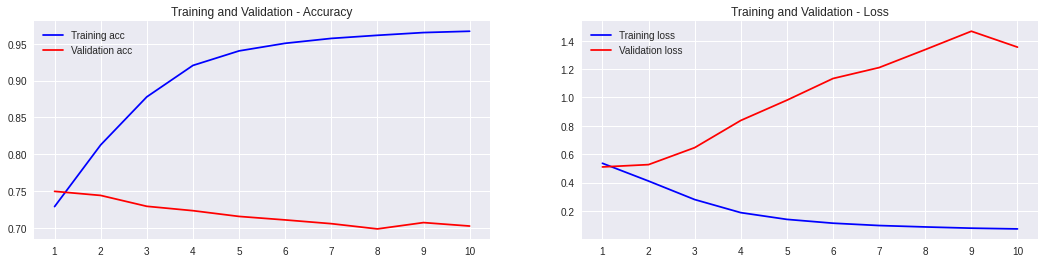

In [ ]:
lossTrainLSTM, accTrainLSTM= lstmModel.evaluate(trainInputs, trainLabels, batch_size=batch_size)
print("The results for the CNN-LSTM model using under training set have an accuracy of {0} and a loss of {1}".format(lossTrainLSTM, accTrainLSTM))

lossTestLSTM, accTestLSTM= lstmModel.evaluate(testInputs, testLabels, batch_size=batch_size)
print("The results for the CNN-LSTM model using under testing set have an accuracy of {0} and a loss of {1}".format(lossTestLSTM, accTestLSTM))

PlotEvaluation(history)

## Final model
The CNN model is here revisited: a additional SpatialDropout layer was added and some of its hyperparameters were tuned.


In [31]:
def FinalModel():

  max_features = targetVocab
  maxlen = maxLength
  embedding_size = 128
  kernel_size = 5
  filters = 64

  print('CNN final model building...')
  model = Sequential()

  model.add(Embedding(max_features, 
                      embedding_size,
                      input_length=maxlen))
  model.add(SpatialDropout1D(0.5))
  model.add(Conv1D(filters,
                  kernel_size,
                  padding='same',
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(1024))
  model.add(Dropout(0.4))
  model.add(Activation('relu'))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  print('Compile CNN final model...')  
  model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['acc'])

  return model

**initialization**

In [ ]:
batch_size = 32
epoch = 10

cnnFinalModel = FinalModel()
cnnFinalModel.summary()

CNN final model building...
Compile CNN final model...
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 58, 128)           8388608   
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 58, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 58, 64)            41024     
_________________________________________________________________
global_max_pooling1d_21 (Glo (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              66560     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
________________________________________________________________

**training**

In [ ]:
checkPath = './checkpoints/cnnFinal-weights-improvement-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkPath, monitor='val_acc', verbose=1, mode='max',save_best_only=True)

history = cnnFinalModel.fit(trainInputs, trainLabels,
          batch_size=batch_size,
          epochs=epoch,
          validation_data=(testInputs, testLabels),
          callbacks = [checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 59s 458us/step - loss: 0.4965 - acc: 0.7552 - val_loss: 0.4498 - val_acc: 0.7888

Epoch 00001: val_acc improved from -inf to 0.78884, saving model to ./checkpoints/cnnFinal-weights-improvement-01.hdf5
Epoch 2/10
128000/128000 [==============================] - 59s 458us/step - loss: 0.3875 - acc: 0.8282 - val_loss: 0.4450 - val_acc: 0.7985

Epoch 00002: val_acc improved from 0.78884 to 0.79850, saving model to ./checkpoints/cnnFinal-weights-improvement-02.hdf5
Epoch 3/10
128000/128000 [==============================] - 59s 458us/step - loss: 0.3121 - acc: 0.8677 - val_loss: 0.4752 - val_acc: 0.7875

Epoch 00003: val_acc did not improve from 0.79850
Epoch 4/10
128000/128000 [==============================] - 58s 451us/step - loss: 0.2514 - acc: 0.8968 - val_loss: 0.5400 - val_acc: 0.7833

Epoch 00004: val_acc did not improve from 0.79850
Epoch 5/10
128000/128000 [==============

**evaluation**

128000/128000 [==============================] - 10s 76us/step
The results for the final model using under training set have an accuracy of 0.04365232822598773 and a loss of 0.9848437309265137
32000/32000 [==============================] - 2s 76us/step
The results for the final model using under testing set have an accuracy of 0.9198314712941646 and a loss of 0.7642187476158142


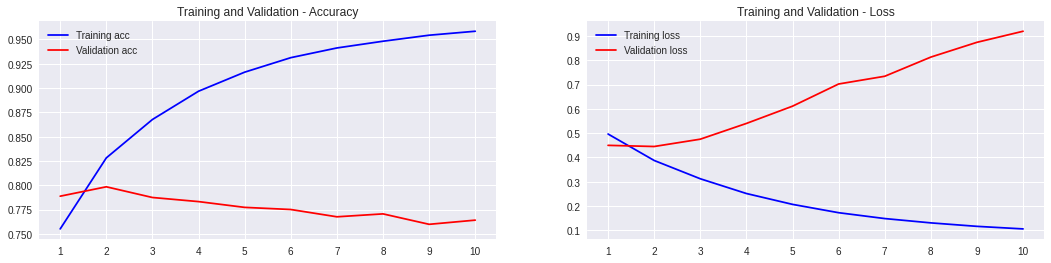

In [ ]:
lossTrainFinal, accTrainFinal= cnnFinalModel.evaluate(trainInputs, trainLabels, batch_size=batch_size)
print("The results for the final model using under training set have an accuracy of {0} and a loss of {1}".format(lossTrainFinal, accTrainFinal))

lossTestFinal, accTestFinal= cnnFinalModel.evaluate(testInputs, testLabels, batch_size=batch_size)
print("The results for the final model using under testing set have an accuracy of {0} and a loss of {1}".format(lossTestFinal, accTestFinal))

PlotEvaluation(history)